In [1]:
import torch
import torch.nn.functional as F
import csv
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [2]:
# https://vincentarelbundock.github.io/Rdatasets/datasets.html
# https://vincentarelbundock.github.io/Rdatasets/doc/Ecdat/Workinghours.html
# https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Workinghours.csv
p = '/app/Contrastive-Learning-Benchmarking//data/Workinghours.csv'

In [3]:
with open(p, 'r') as file:
    my_reader = csv.reader(file, delimiter=',')
    rows = [r for r in my_reader]

In [4]:
rows

[['',
  'hours',
  'income',
  'age',
  'education',
  'child5',
  'child13',
  'child17',
  'nonwhite',
  'owned',
  'mortgage',
  'occupation',
  'unemp'],
 ['1', '2000', '350', '26', '12', '0', '1', '0', '0', '1', '1', 'swcc', '7'],
 ['2', '390', '241', '29', '8', '0', '1', '1', '0', '1', '1', 'other', '4'],
 ['3', '1900', '160', '33', '10', '0', '2', '0', '0', '1', '0', 'swcc', '7'],
 ['4', '0', '80', '20', '9', '2', '0', '0', '0', '1', '1', 'other', '7'],
 ['5', '3177', '456', '33', '12', '0', '2', '0', '0', '1', '1', 'swcc', '7'],
 ['6', '0', '390', '22', '12', '2', '0', '0', '0', '1', '1', 'other', '7'],
 ['7', '0', '181', '41', '9', '0', '0', '1', '0', '1', '0', 'swcc', '7'],
 ['8', '1040', '726', '31', '16', '2', '1', '0', '0', '1', '1', 'mp', '3'],
 ['9', '2040', '-5', '33', '12', '0', '3', '0', '0', '0', '0', 'fr', '4'],
 ['10', '0', '78', '30', '11', '1', '1', '0', '0', '0', '0', 'other', '5'],
 ['11', '1432', '195', '41', '12', '0', '1', '0', '1', '1', '1', 'other', '7'],


In [5]:
hours = [int(r[rows[0].index('hours')])//100  for r in rows[1:]]
income = [int(r[rows[0].index('income')])//100 for r in rows[1:]]
education = [int(r[rows[0].index('education')]) for r in rows[1:]]
age = [int(r[rows[0].index('age')]) for r in rows[1:]]
nonwhite = [int(r[rows[0].index('nonwhite')]) for r in rows[1:]]

(array([186., 586., 546., 638., 394., 269., 224., 160., 219., 160.]),
 array([18. , 22.6, 27.2, 31.8, 36.4, 41. , 45.6, 50.2, 54.8, 59.4, 64. ]),
 <BarContainer object of 10 artists>)

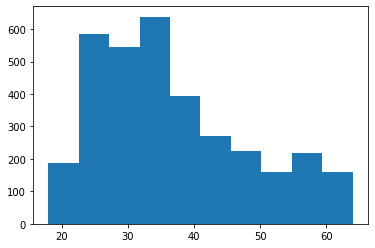

In [6]:
plt.hist(age)

(array([1.202e+03, 3.880e+02, 6.080e+02, 1.062e+03, 9.500e+01, 2.200e+01,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0. ,  5.8, 11.6, 17.4, 23.2, 29. , 34.8, 40.6, 46.4, 52.2, 58. ]),
 <BarContainer object of 10 artists>)

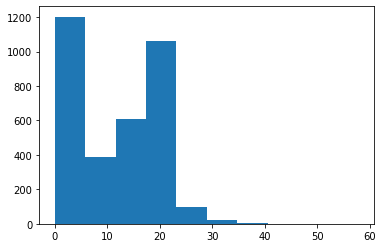

In [7]:
plt.hist(hours)

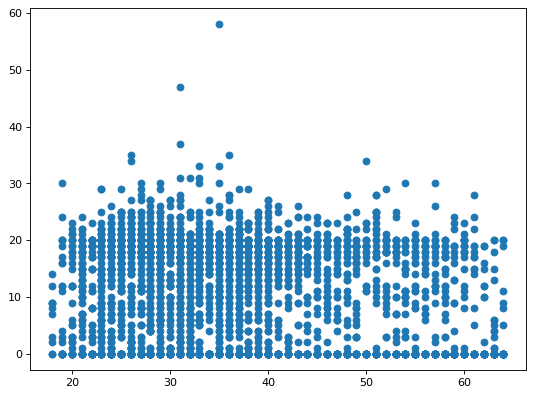

In [8]:
# x- age
# y - hours
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(age, hours)

In [9]:
max(hours), min(hours)

(58, 0)

In [10]:
max(age), min(age)

(64, 18)

In [11]:
# x axis -- age -- -18 - 64
# y axis -- hours -- 0 - 58
count_table = np.zeros((64-(18)+1, 58-0+1))

for a, h in zip(age, hours):
    count_table[int(a)-(18),int(h)-0] += 1
 

xy = count_table/np.sum(count_table) + 0.00001
xy = xy/np.sum(xy)
xy.shape

(47, 59)

In [12]:
np.sum(count_table)

3382.0

In [12]:
count_table.shape

(47, 59)

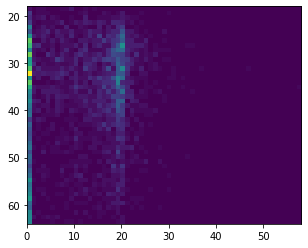

In [17]:
plt.imshow(xy, extent=[0,58, 64,18])

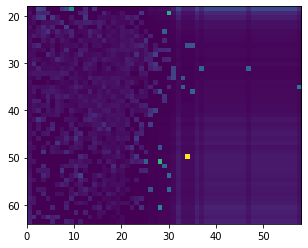

In [18]:
x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]
plt.imshow(xy/xyind, extent=[0,58, 64,18])

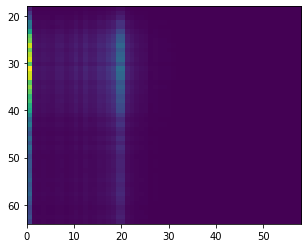

In [19]:
plt.imshow(xyind, extent=[0,58, 64,18])

In [15]:
def run_expr4(n_batch, iters):
    '''
    model pxy directly
    '''
    torch.manual_seed(42)
    
    M = torch.randn(xy.shape, requires_grad = True, device='cuda')
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}

    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
#         import pdb; pdb.set_trace()
        
        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi = F[samples[i,0],samples[i,1]]/torch.sum(F[:,:])
            loss = loss + torch.log(lossi) 
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 500 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy(), extent=[0,58, 72,-2])
            plt.savefig(f"Workinghours_training_results/Mbar_joint_{n_batch}_{iteration}.png")

    np.save(f'Workinghours_training_results/Mbar_joint_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'Workinghours_training_results/M_joint_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'Workinghours_training_results/training_loss_joint_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 1/1999 [00:00<06:34,  5.07it/s]

tensor([ 0.1940,  2.1614, -0.1721,  0.8491, -1.9244], device='cuda:0',
       grad_fn=<SliceBackward>)


 50%|█████     | 1000/1999 [03:23<03:36,  4.62it/s]

tensor(4.7466, device='cuda:0', grad_fn=<VarBackward0>)


100%|██████████| 1999/1999 [07:03<00:00,  4.72it/s]


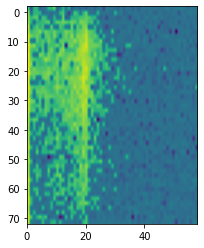

In [16]:
# model pxy directly
M, Mbar, history = run_expr4(n_batch=500, iters=2000)

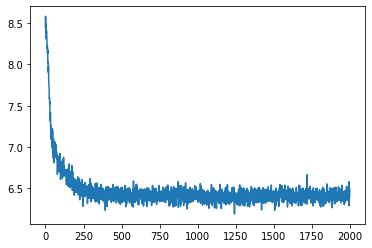

In [17]:
plt.plot(history['loss'])

In [21]:
Mbar_joint = torch.from_numpy(np.load(f'Workinghours_training_results/Mbar_joint_{500}_{1999}.npy'))
M_joint = torch.from_numpy(np.load(f'Workinghours_training_results/M_joint_{500}_{1999}.npy'))

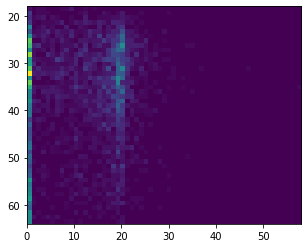

In [22]:
plt.imshow(torch.exp(Mbar_joint), extent=[0,58, 64,18])

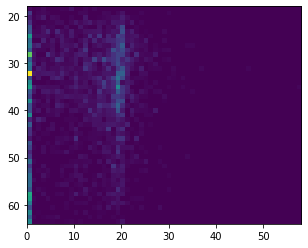

In [23]:
plt.imshow(torch.exp(M_joint), extent=[0,58, 64,18])

In [22]:
# Compare Mbar with xy
F_joint = torch.exp(Mbar_joint)
F_joint_normalized = F_joint/torch.sum(F_joint)
log_F_joint_normalized = torch.log(F_joint_normalized)

F.kl_div(log_F_joint_normalized, torch.from_numpy(xy))

/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(1.0387e-06, dtype=torch.float64)

In [29]:
def run_expr5(n_batch, iters):
    '''
    model x|y and y|x
    '''
    torch.manual_seed(42)
    
    M = torch.randn(xy.shape, requires_grad = True)#, device='cuda')
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}

    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
#         import pdb; pdb.set_trace()
        
        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], range(xy.shape[1])])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[range(xy.shape[0]), samples[i,1]])

            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
            
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 500 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy(), extent=[0,58, 72,-2])
            plt.savefig(f"Workinghours_training_results/Mbar_pseudo_{n_batch}_{iteration}.png")

    np.save(f'Workinghours_training_results/Mbar_pseudo_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'Workinghours_training_results/M_pseudo_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'Workinghours_training_results/training_loss_pseudo_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 0/1999 [00:00<?, ?it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784], grad_fn=<SliceBackward>)


 25%|██▌       | 500/1999 [01:45<05:47,  4.31it/s]

tensor(4.6974, grad_fn=<VarBackward0>)


 50%|█████     | 1000/1999 [03:36<04:06,  4.05it/s]

tensor(4.5367, grad_fn=<VarBackward0>)


 75%|███████▌  | 1500/1999 [05:14<01:43,  4.82it/s]

tensor(4.4170, grad_fn=<VarBackward0>)


100%|██████████| 1999/1999 [06:52<00:00,  4.84it/s]


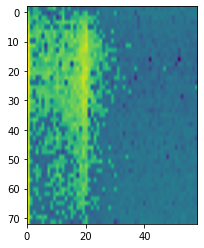

In [30]:
# model pxy directly
M, Mbar, history = run_expr5(n_batch=500, iters=2000)

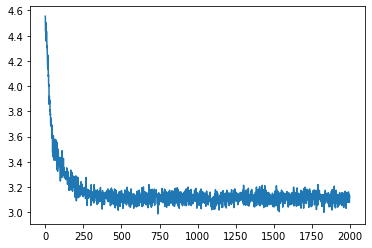

In [31]:
plt.plot(history['loss'])

In [24]:
Mbar_pseudo = torch.from_numpy(np.load(f'Workinghours_training_results/Mbar_pseudo_{500}_{1999}.npy'))
M_pseudo = torch.from_numpy(np.load(f'Workinghours_training_results/M_pseudo_{500}_{1999}.npy'))

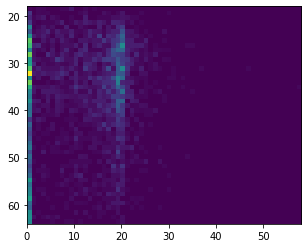

In [25]:
plt.imshow(torch.exp(Mbar_pseudo), extent=[0,58, 64,18])

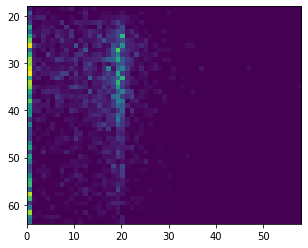

In [26]:
plt.imshow(torch.exp(M_pseudo), extent=[0,58, 64,18])

In [35]:
# Compare Mbar with xy
F_pseudo = torch.exp(Mbar_pseudo)
F_pseudo_normalized = F_pseudo/torch.sum(F_pseudo)
log_F_pseudo_normalized = torch.log(F_pseudo_normalized)

F.kl_div(log_F_pseudo_normalized, torch.from_numpy(xy))

tensor(1.4424e-06, dtype=torch.float64)

In [36]:
def run_expr(n_batch, iters):
    '''
    info NCE
    '''
    torch.manual_seed(42)
    
    M = torch.randn(xy.shape, requires_grad = True)#, device='cuda')
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}

    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
#         import pdb; pdb.set_trace()
        
        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
#             lossi = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], samples[:,1]])
            
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], samples[:,1]])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[:,0], samples[i,1]])
            
            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
            
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 500 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy(), extent=[0,58, 72,-2])
            plt.savefig(f"Workinghours_training_results/Mbar_infoNCE_{n_batch}_{iteration}.png")

    np.save(f'Workinghours_training_results/Mbar_infoNCE_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'Workinghours_training_results/M_infoNCE_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'Workinghours_training_results/training_loss_infoNCE_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 0/1999 [00:00<?, ?it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784], grad_fn=<SliceBackward>)


 25%|██▌       | 500/1999 [01:37<05:19,  4.69it/s]

tensor(1.6898, grad_fn=<VarBackward0>)


 50%|█████     | 1000/1999 [03:15<03:24,  4.89it/s]

tensor(1.6583, grad_fn=<VarBackward0>)


 75%|███████▌  | 1500/1999 [04:53<01:43,  4.81it/s]

tensor(1.6443, grad_fn=<VarBackward0>)


100%|██████████| 1999/1999 [06:30<00:00,  5.12it/s]


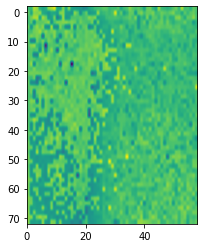

In [37]:
# info NCE both directions
M, Mbar, history = run_expr(n_batch=500, iters=2000)

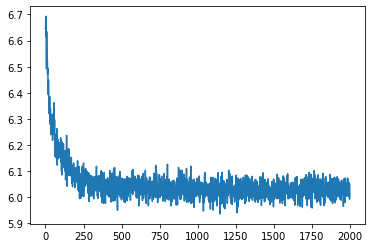

In [38]:
plt.plot(history['loss'])

In [27]:
Mbar_infoNCE = torch.from_numpy(np.load(f'Workinghours_training_results/Mbar_infoNCE_{500}_{1999}.npy'))
M_infoNCE = torch.from_numpy(np.load(f'Workinghours_training_results/M_infoNCE_{500}_{1999}.npy'))

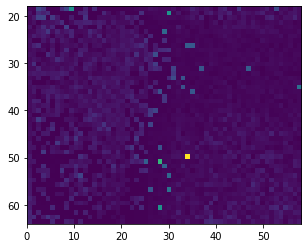

In [28]:
plt.imshow(torch.exp(Mbar_infoNCE), extent=[0,58, 64,18])

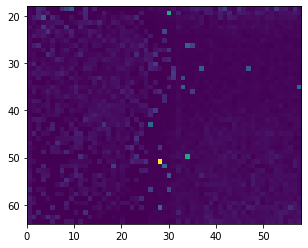

In [29]:
plt.imshow(torch.exp(M_infoNCE), extent=[0,58, 64,18])

In [42]:
# Compare Mbar with xy
F_infoNCE = torch.exp(Mbar_infoNCE)
F_infoNCE_normalized = F_infoNCE/torch.sum(F_infoNCE)
log_F_infoNCE_normalized = torch.log(F_infoNCE_normalized)

F.kl_div(log_F_infoNCE_normalized, torch.from_numpy(xy))

tensor(0.0004, dtype=torch.float64)